# Basic PCNN manual -  Planar Earth-Mars Transfer and Rendez-Vous
#### Mitchell van Doorn
In this manual, I will walk you through the code that implements the Basic PCNN model. The toy problem used in this example is a low thrust transfer departing from the SOI of Earth with zero excess velocity and arriving at Mars, also with zero excess velocity, after 2 full revolutions.

First, make sure the backend used by DeepXDE is tensorflow. Depending on this backend, DeepXDE uses specific functions and my code does not work with other backends, also not the tensorflow.compat.v1 backend.

In [12]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle"""
import os
os.environ["DDE_BACKEND"] = "tensorflow"

Now import all required libraries:

In [13]:
import deepxde as dde
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
import tensorflow as tf
import master_thesis_mitchell_functions as mtmf
import matplotlib.pyplot as plt
import verification
import coordinates_transformation_functions
import plots
import time
from datetime import datetime
start_time = time.time()

First let's define some constants and the initial and final state:

In [14]:
# Constants
MU = 1.32712440042e20 # gravitational parameter of Sun
m0 = 100 # spacecraft initial mass
AU = 149597870700 # [m]
a = 10 # steepness parmater
umax = 0.1 # max allowable thrust
isp = 2500 # specific impulse

# Initial state
r0 = AU
theta0 = 0
vr0 = 0
vtheta0 = np.sqrt(MU/r0)
initial_state = np.array([r0, theta0, vr0, vtheta0])

# Final state
rfinal = 1.5*r0
theta_final = 4*np.pi
vr_final = 0
vtheta_final = np.sqrt(MU/rfinal)
final_state = np.array([rfinal, theta_final, vr_final, vtheta_final])

Then non-dimensionalize the parameters:

In [15]:
# Non-dimensionalization parameters
length_scale = r0
t_scale = length_scale / vtheta0

# Non-dimensionalize iniitial and final states
initial_state[0] /= length_scale
initial_state[2:] *= t_scale/length_scale
final_state[0] /= length_scale
final_state[2:] *= t_scale/length_scale

Define the integration times, loss weights and save parameters into a dictionary named config:

In [16]:
# Integration times
days = 1000
t0 = 0
tfinal = days*24*3600 # Constant time of flight
M = 200 # Amount of collocation points

# Loss weights
dyn_weight = 1
m_weigth = 1e-5 # mass term
o_weigth = 1e-7 # objective term

# create config dictionary
config = {"t0": t0,
          "tfinal": tfinal,
          "length_scale": length_scale,
          "t_scale": t_scale,
          "isp": isp,
          "m0": m0,
          "M": M,
          "metrics": ["FinalDr", "FinalDv", "FinalDm", "Fuel used" ],
          "N_train": M,
          "N_test": M,
          "layer_architecture_FNN": [1, 20, 20, 20, 20, 20, 7],
          "layer_architecture_PFNN": [1, [10,10,10,10,10,10,10], [10,10,10,10,10,10,10], [10,10,10,10,10,10,10], 7],
          "loss_weights": [dyn_weight, dyn_weight, dyn_weight, dyn_weight, m_weigth, o_weigth],
          "mass": True
}

Then define the loss function and the constraint layer of the PCNN:

In [1]:
def loss_function(t, y):
    x1 = y[:, 0:1]
    theta = y[:, 1:2]  # unused
    x2 = y[:, 2:3]
    x3 = y[:, 3:4]
    ur = y[:, 4:5]
    ut = y[:, 5:6]
    m = y[:, 6:7]
    # tf.print(m)

    # Thrust magnitude
    T = tf.reshape(tf.norm(y[:, 4:6], axis=1), (-1, 1))
    # tf.print("T:   ,", T)

    delta_t = t[1:] - t[:-1]
    L_o = (1 / (isp * 9.81)) * 0.5 * (T[:-1] * t_scale + T[1:] * t_scale) * delta_t

    # LHS EOMs - Derivatives
    dx1_dt = dde.grad.jacobian(y, t, i=0)
    dtheta_dt = dde.grad.jacobian(y, t, i=1)
    dx2_dt = dde.grad.jacobian(y, t, i=2)
    dx3_dt = dde.grad.jacobian(y, t, i=3)
    dm_dt = dde.grad.jacobian(y, t, i=6)

    # RHS EOMs
    RHS_x1 = x2
    RHS_theta = x3 / x1
    RHS_x2 = x3 ** 2 / x1 - (MU * t_scale ** 2 / length_scale ** 3) * x1 ** (-2) + (t_scale ** 2 / length_scale) * ur / m
    RHS_x3 = - (x2 * x3) / x1 + (t_scale ** 2 / length_scale) * ut / m
    RHS_m = -T * t_scale / (isp * 9.81)

    # Return the residuals
    return [
        dx1_dt - RHS_x1,
        dtheta_dt - RHS_theta,
        dx2_dt - RHS_x2,
        dx3_dt - RHS_x3,
        dm_dt - RHS_m,
        # L_o
        ]
def constraint_layer(t, y):

    c1 = tf.math.exp(-a * (t - t0))
    c2 = 1 - tf.math.exp(-a * (t - t0)) - tf.math.exp(a * (t - tfinal/t_scale))
    c3 = tf.math.exp(a * (t - tfinal/t_scale))
    c_mass = 1 - tf.math.exp(-a * (t - t0))

    # Apply sigmoid to get in [0, 1], while keeping a non-zero derivative for training
    u_norm = tf.math.sigmoid(y[:, 4:5])
    u_angle = tf.math.tanh(y[:, 5:6])
    Nm = tf.math.sigmoid(y[:, 6:7])

    # Rescale the U_R and the U_theta to their real values
    u_norm = u_norm * umax
    u_angle = u_angle * 2 * np.pi

    # Transform the control to cartesian coordinates
    ur = u_norm * tf.math.sin(u_angle)
    ut = u_norm * tf.math.cos(u_angle)

    output = tf.concat([c1 * initial_state[0] + c2 * y[:, 0:1] + c3 * final_state[0],
                        c1 * initial_state[1] + c2 * y[:, 1:2] + c3 * final_state[1],
                        c1 * initial_state[2] + c2 * y[:, 2:3] + c3 * final_state[2],
                        c1 * initial_state[3] + c2 * y[:, 3:4] + c3 * final_state[3],
                        ur,
                        ut,
                        m0 - c_mass * m0 * Nm], axis=1
                       )

    return output

Define the learning rate schedule, which adapts the learning rate during training:

In [18]:
lr_schedule = [(1e-2, 3000), (1e-3, 5000), (1e-4, 10000), (5e-3, 4000), (1e-4, 5000), (5e-3, 4000), (1e-4, 5000), (5e-3, 4000), (1e-4, 5000), (1e-5, 6000)]

Now it's time to train the model. A seed that converges to a solution is used below. Fill in seed=None for a time dependent seed. Be mindful that convergence depends on the initialization of the network, so not all seeds converge to a useful solution. The runtime is quite long, but this is faster when using an IDE (like Pycharm or Spyder).

In [19]:
losshistory, train_state = mtmf.single_run(config, loss_function, constraint_layer, lr_schedule, train_distribution="uniform", std=None, save=True, seed=20241114154348)

manually entered seed: 20241114154348
Learning rate= 0.01 Iterations= 3000
Compiling model...
'compile' took 0.000241 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.36e+00, 9.49e+01, 6.36e+05, 1.60e+00, 1.59e-02, 2.12e-05]    [2.37e+00, 9.55e+01, 1.57e+06, 1.61e+00, 1.60e-02, 2.12e-05]    []  
1000      [2.29e-01, 4.52e-04, 5.93e-03, 3.42e-03, 1.23e-03, 2.27e-05]    [2.30e-01, 4.52e-04, 5.93e-03, 3.43e-03, 1.23e-03, 2.27e-05]    []  
2000      [2.23e-01, 9.76e-04, 5.98e-03, 2.13e-03, 3.23e-04, 1.50e-05]    [2.24e-01, 9.76e-04, 5.98e-03, 2.14e-03, 3.23e-04, 1.50e-05]    []  
3000      [2.18e-01, 2.48e-04, 4.86e-03, 1.83e-03, 2.88e-04, 1.24e-05]    [2.19e-01, 2.48e-04, 4.86e-03, 1.84e-03, 2.88e-04, 1.24e-05]    []  

Best model at step 3000:
  train loss: 2.25e-01
  test loss: 2.27e-01
  test metric: []

'train' took 24.602125 s

Learning rate= 0.001 I

Lastly, verify the model and plot the results of the solution.

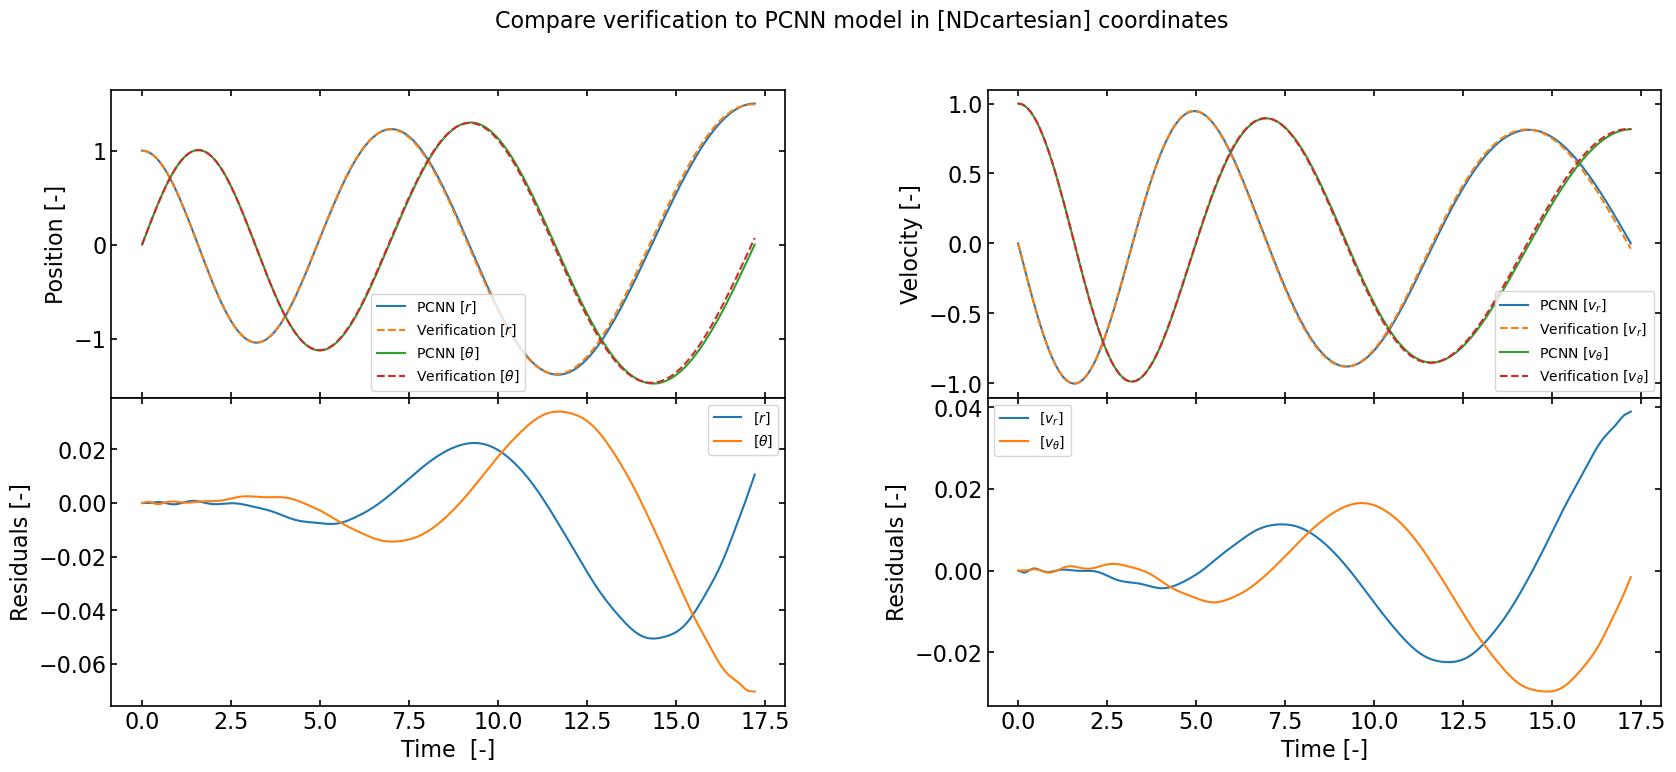

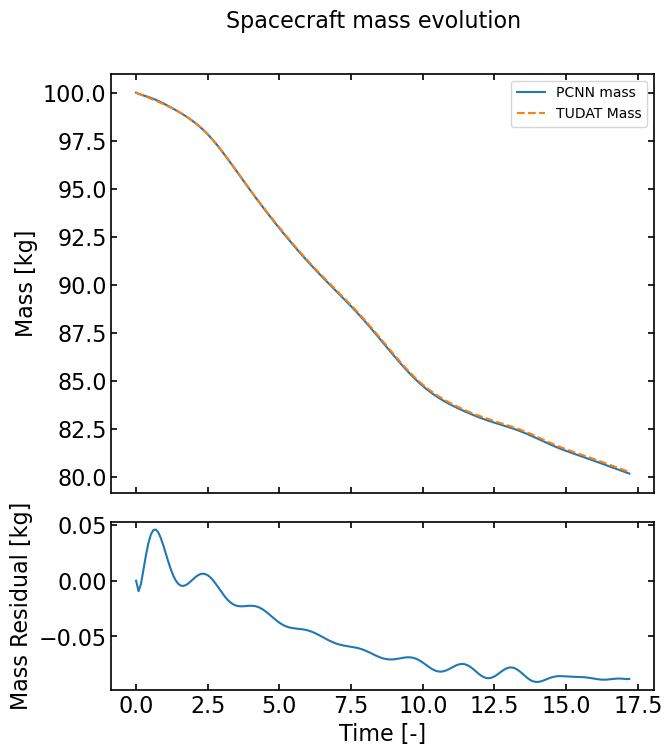

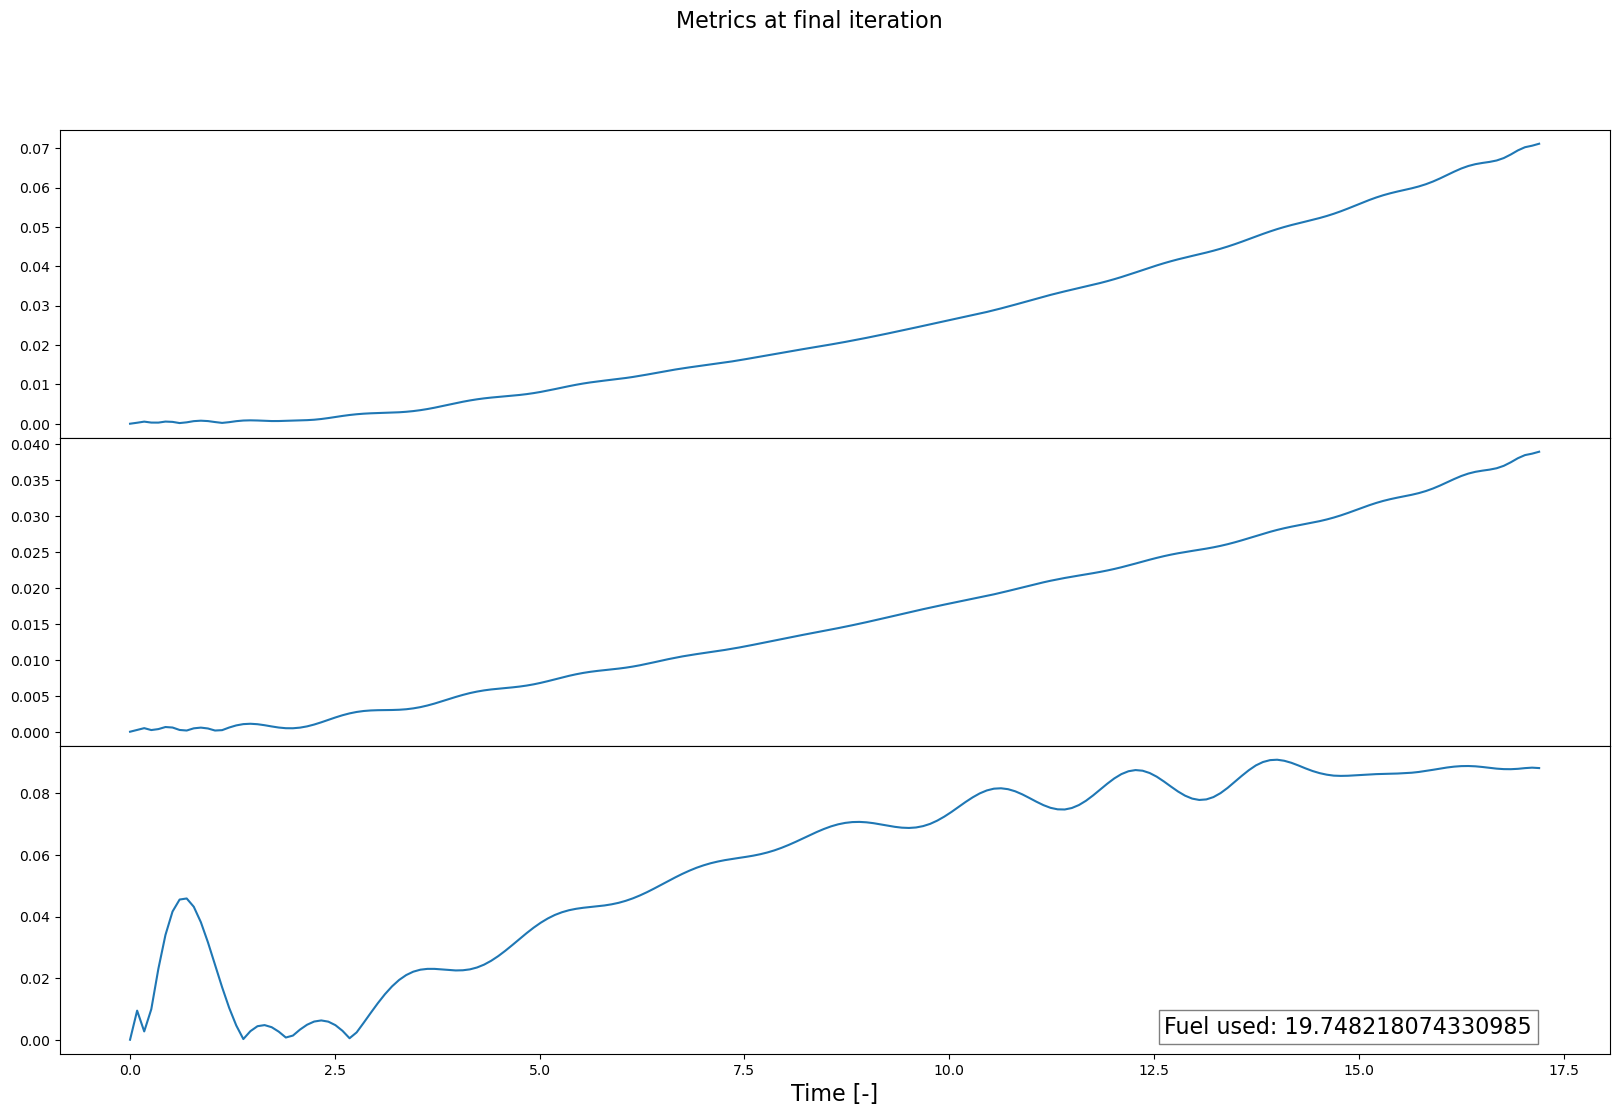

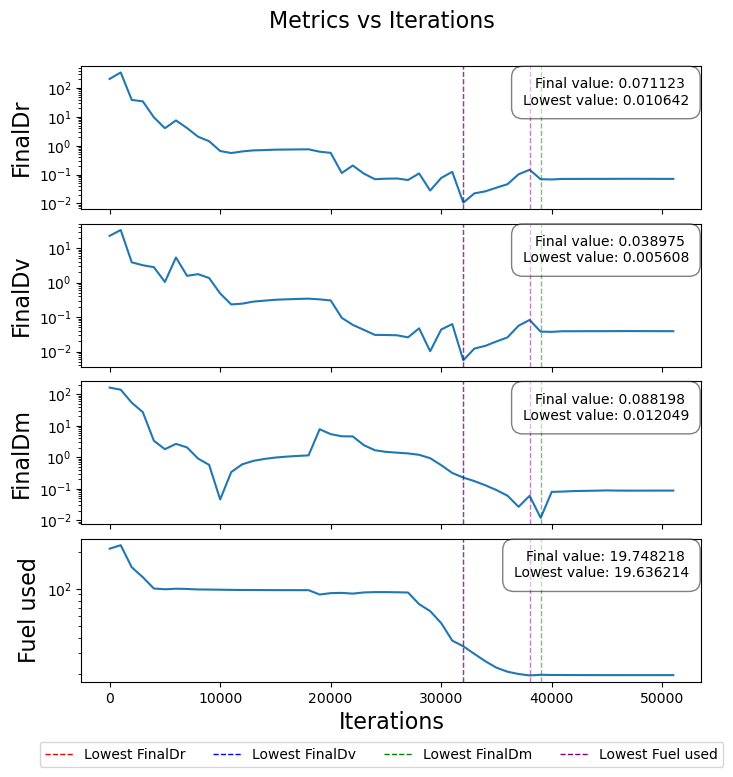

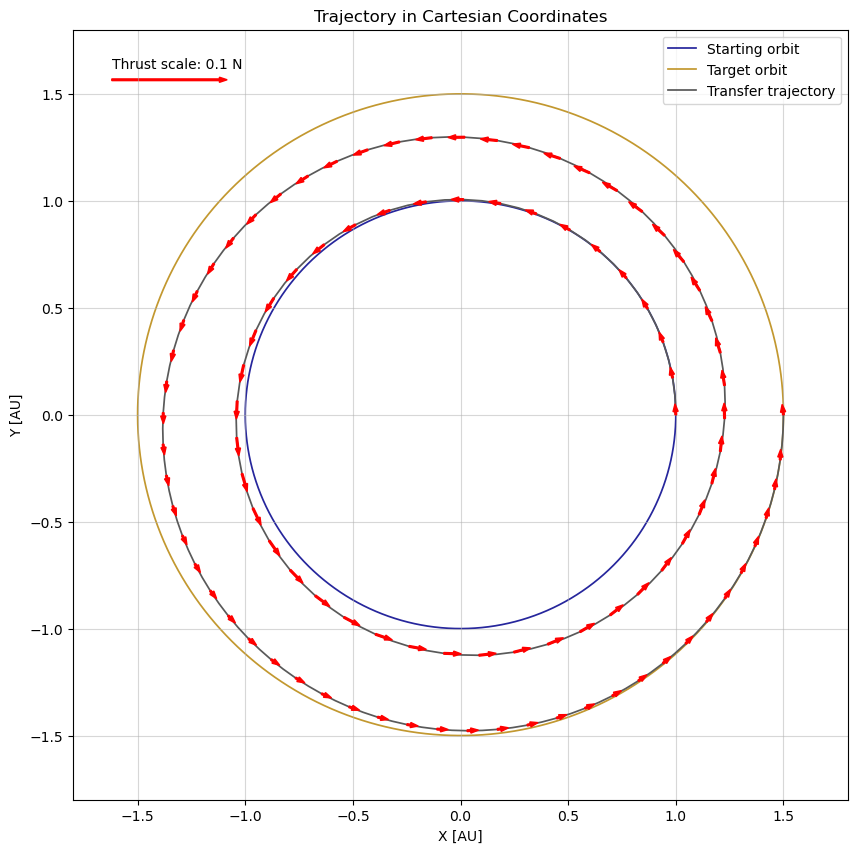

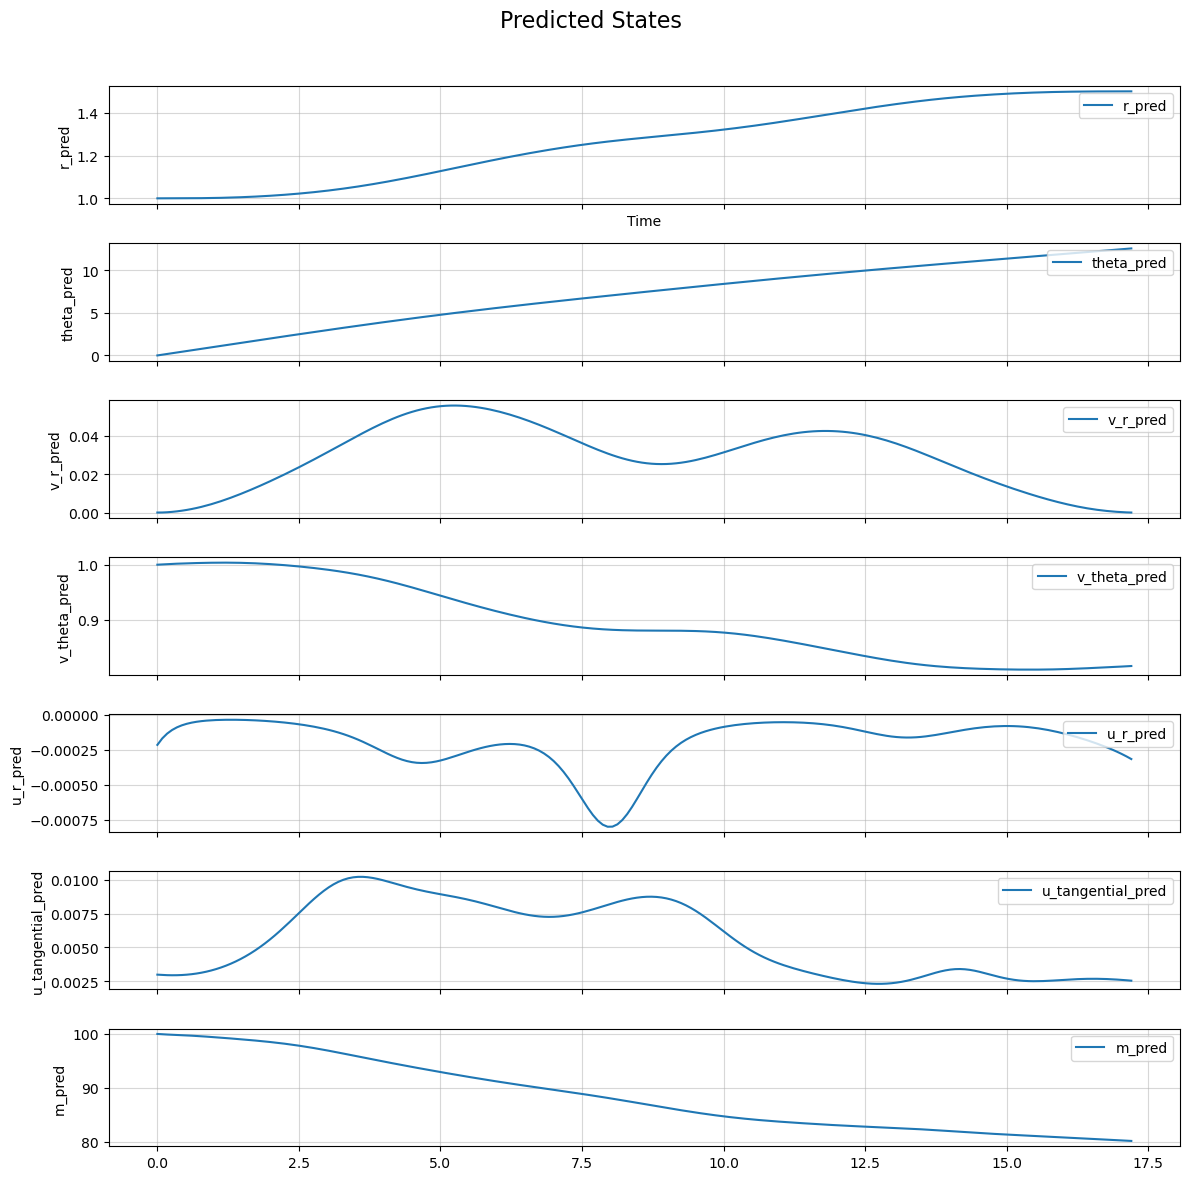

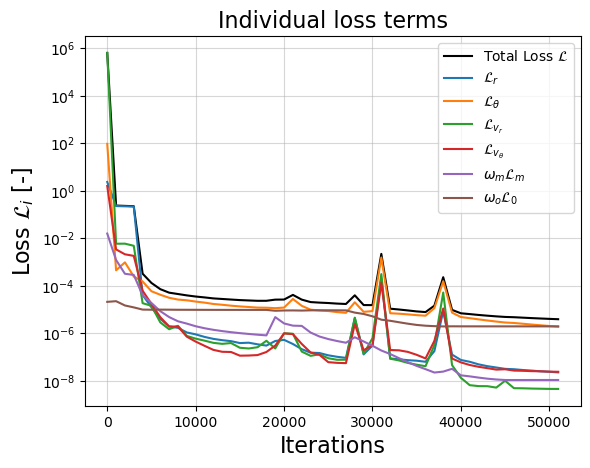

Entire run took 446.9 s


In [20]:
# Verification
# mtmf.verify_basic_pcnn(f'{run_id_number}_FNN')
mtmf.verify_run(train_state.best_y, losshistory, config, showplot=True, saveplots=True)

# plots
plots.plot_trajectory_radialND_to_cartesianND(train_state.best_y, r_target = 1.5, r_start = 1, N_arrows=100,  config=config)
plots.plot_states(train_state.best_y, config)
plots.plot_loss(losshistory, mass=config['mass'])
plt.show()

end_time = time.time()
print(f"Entire run took {np.round(end_time-start_time, 1)} s")
plt.close()